<a href="https://colab.research.google.com/github/sanchezc137dd/Procesamiento-computacional-para-la-digitalisacion-3d-de-tomografias-/blob/main/prototipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paso 1: Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paso 2: Importar librerías
import os
import cv2
import matplotlib.pyplot as plt

# Paso 3: Ruta corregida
folder_path = "/content/drive/MyDrive/UR/Projections/"  # ✅ Ruta correcta según tus archivos

# Paso 4: Listar imágenes PNG
imagenes = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.png')])

print("📂 Imágenes encontradas:")
for img in imagenes:
    print(" -", img)

# Paso 5: Mostrar cada imagen
for nombre in imagenes:
    ruta_img = os.path.join(folder_path, nombre)
    imagen = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)

    if imagen is None:
        print(f"⚠️ No se pudo cargar la imagen: {nombre}")
    else:
        plt.figure(figsize=(6,6))
        plt.imshow(imagen, cmap='gray')
        plt.title(f"Imagen: {nombre}")
        plt.axis('off')
        plt.show()


Mounted at /content/drive
📂 Imágenes encontradas:


Mounted at /content/drive


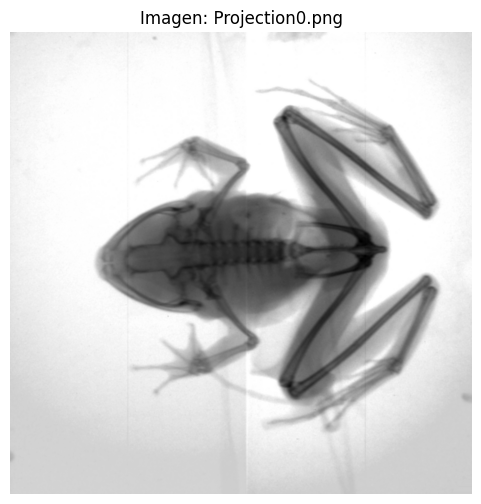

In [ ]:
# Paso 1: Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paso 2: Importar librerías
import os
import cv2
import matplotlib.pyplot as plt

# Paso 3: Ruta directa a la imagen
ruta_img = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"

# Paso 4: Verificar existencia del archivo
if not os.path.exists(ruta_img):
    print(f"❌ El archivo no existe en la ruta: {ruta_img}")
else:
    # Cargar imagen en escala de grises
    imagen = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)

    if imagen is None:
        print(f"⚠️ No se pudo cargar la imagen. Puede estar corrupta o no ser compatible.")
    else:
        # Mostrar imagen
        plt.figure(figsize=(6,6))
        plt.imshow(imagen, cmap='gray')
        plt.title("Imagen: Projection0.png")
        plt.axis('off')
        plt.show()


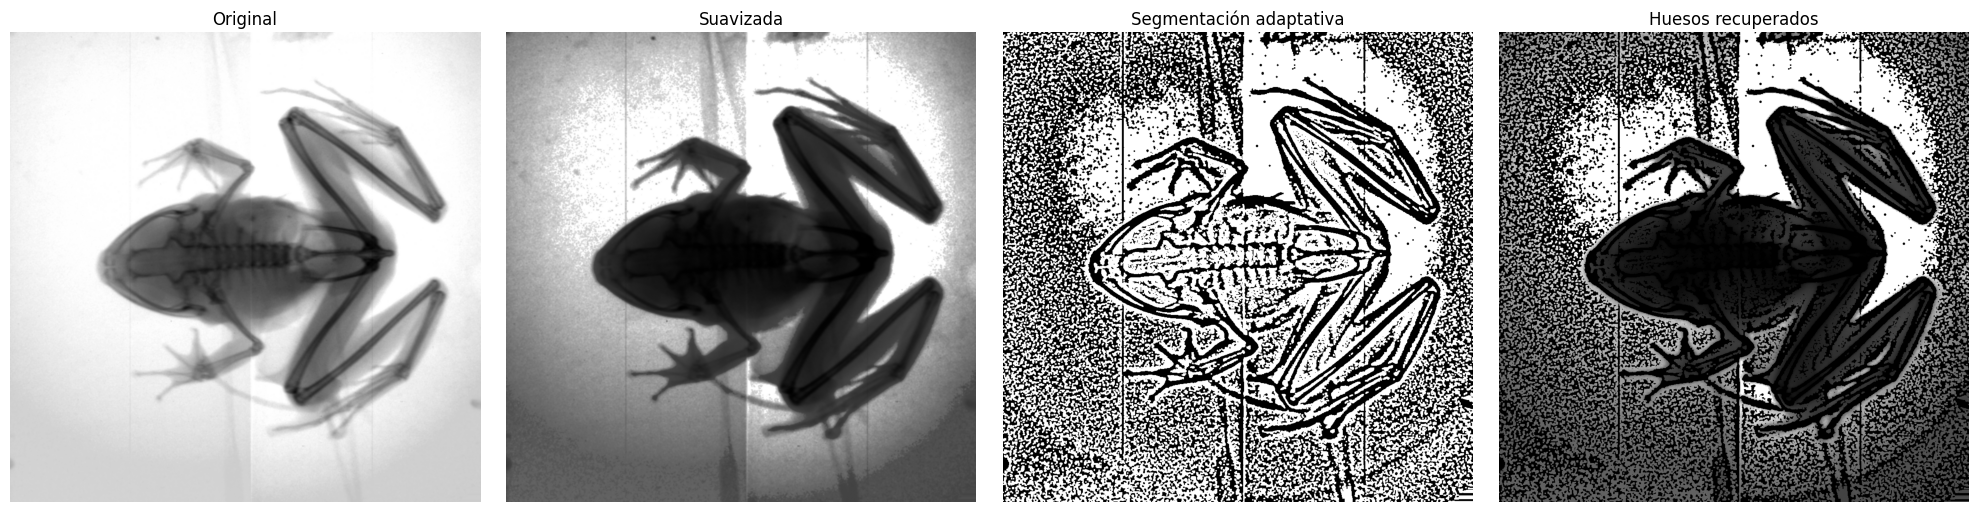

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ruta a la imagen
ruta_img = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"
imagen = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)

if imagen is None:
    print("⚠️ No se pudo cargar la imagen.")
else:
    # Paso 1: Ecualizar histograma
    ecualizada = cv2.equalizeHist(imagen)

    # Paso 2: Suavizado Gaussian para reducir ruido sin borrar bordes
    suavizada = cv2.GaussianBlur(ecualizada, (3,3), 0)

    # Paso 3: Umbral adaptativo más sensible
    adaptativo = cv2.adaptiveThreshold(
        suavizada, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=21,  # Vecindario más amplio
        C=1            # Menor compensación
    )

    # Paso 4: Morfología para limpiar ruido fino
    kernel = np.ones((3,3), np.uint8)
    limpio = cv2.morphologyEx(adaptativo, cv2.MORPH_OPEN, kernel, iterations=1)

    # Paso 5: Combinación con la ecualizada para recuperar zonas débiles
    combinado = cv2.bitwise_and(ecualizada, limpio)

    # Paso 6: Mostrar resultados
    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.imshow(imagen, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(suavizada, cmap='gray')
    plt.title("Suavizada")
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(limpio, cmap='gray')
    plt.title("Segmentación adaptativa")
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(combinado, cmap='gray')
    plt.title("Huesos recuperados")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install opencv-python scikit-image matplotlib torch torchvision --quiet
!pip install git+https://github.com/facebookresearch/segment-anything.git --quiet


  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth


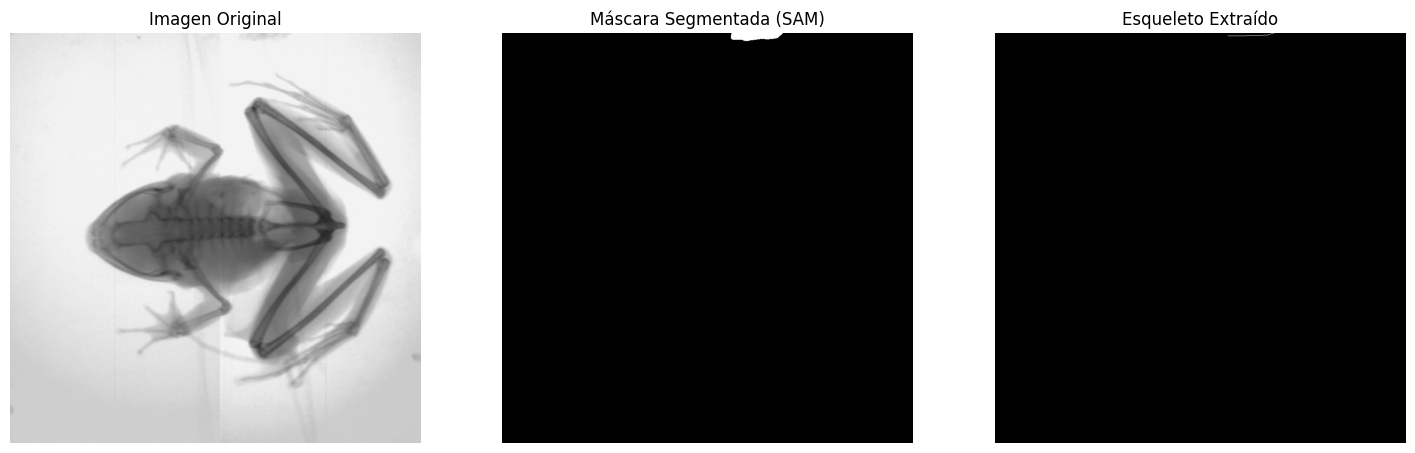

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch

# === 1. Ruta en tu Drive ===
ruta_img = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"

# Cargar imagen
img = cv2.imread(ruta_img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === 2. Cargar modelo SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth").to(device)
mask_gen = SamAutomaticMaskGenerator(sam)

# === 3. Generar máscaras ===
masks = mask_gen.generate(img_rgb)

# escoge la máscara más grande (más área)
mask = max(masks, key=lambda x: x['area'])['segmentation']
mask_uint8 = mask.astype(np.uint8)

# === 4. Skeletonize ===
skeleton = skeletonize(mask_uint8)

# === 5. Mostrar resultados ===
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Máscara Segmentada (SAM)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(skeleton, cmap='gray')
plt.title("Esqueleto Extraído")
plt.axis('off')

plt.show()


SAM fue entrenado para segmentar objetos visibles al ojo humano, no estructuras internas en rayos X.
Para SAM, tu imagen es solo una mancha gris homogénea, no un "objeto claro con bordes".

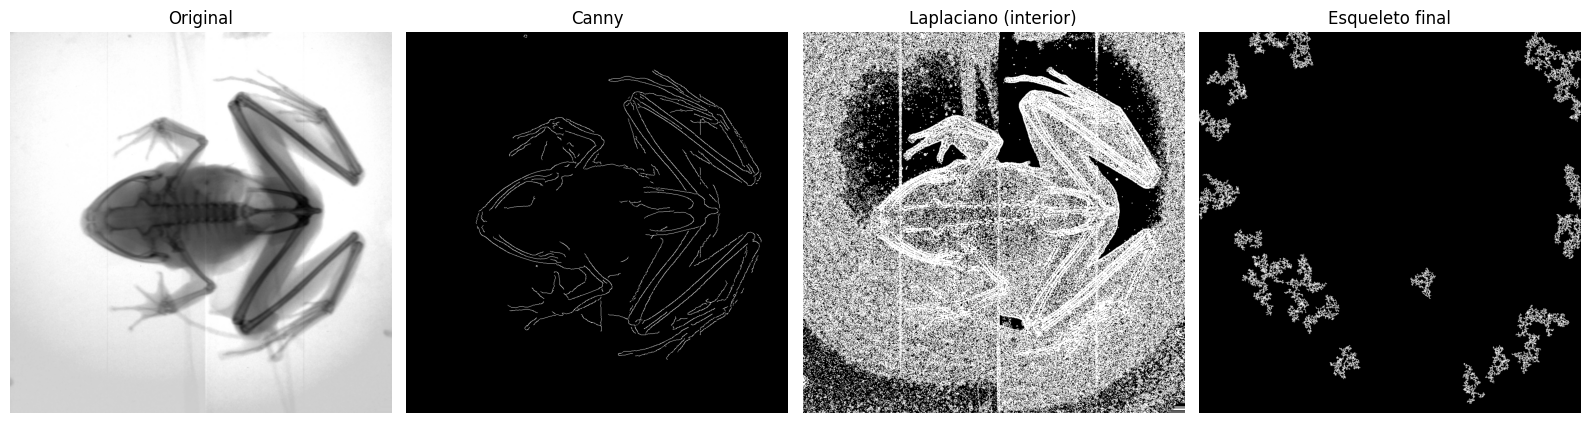

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects

img_path = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Normalizar
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# --- CANNY ---
blur = cv2.GaussianBlur(img_norm, (5, 5), 1.2)
edges_canny = cv2.Canny(blur, 25, 70)

# --- LAPLACIANO (resalta interior de huesos débiles) ---
laplace = cv2.Laplacian(img_norm, cv2.CV_64F, ksize=5)
laplace = cv2.convertScaleAbs(laplace)

# Binarizar Laplaciano para mantener solo intensidades altas
_, lap_bin = cv2.threshold(laplace, 25, 255, cv2.THRESH_BINARY)

# --- COMBinar bordes externos + estructuras internas ---
mix = cv2.bitwise_or(edges_canny, lap_bin)

# --- SKELETON 1px ---
skel = skeletonize(mix > 0).astype(np.uint8) * 255

# --- LIMPIEZA ---
skel_clean = remove_small_objects(skel.astype(bool), min_size=1000)
skel_clean = (skel_clean * 255).astype(np.uint8)

# --- Visualización ---
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(edges_canny, cmap='gray'); axs[1].set_title("Canny")
axs[2].imshow(lap_bin, cmap='gray'); axs[2].set_title("Laplaciano (interior)")
axs[3].imshow(skel_clean, cmap='gray'); axs[3].set_title("Esqueleto final")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
!pip uninstall -y timm segmentation-models-pytorch
!pip install --no-cache-dir timm==0.4.12
!pip install --no-cache-dir segmentation-models-pytorch==0.3.0


Found existing installation: timm 0.4.12
Uninstalling timm-0.4.12:
  Successfully uninstalled timm-0.4.12
Found existing installation: segmentation-models-pytorch 0.3.0
Uninstalling segmentation-models-pytorch-0.3.0:
  Successfully uninstalled segmentation-models-pytorch-0.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 119.5 MB/s eta 0:00:00


In [ ]:
# ======== Instala dependencias (EJECUTAR SOLO UNA VEZ) ========
!pip uninstall -y timm segmentation-models-pytorch
!pip install --no-cache-dir timm==0.4.12
!pip install --no-cache-dir segmentation-models-pytorch==0.3.0
!pip install -q torchmetrics albumentations --quiet


Found existing installation: timm 0.4.12
Uninstalling timm-0.4.12:
  Successfully uninstalled timm-0.4.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 147.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 36.4 MB/s eta 0:00:00


In [ ]:
# ======== Código principal ========
import os, random, time
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from sklearn.model_selection import train_test_split
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torchvision import transforms

# ----- Config -----
IMG_PATH = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"
OUT_DIR = "/content/drive/MyDrive/UR/Projections/pristimantis/unet_refine"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRINT_EVERY = 1

# Hyperparams (ajusta si quieres)
PATCH_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20     # Ajusta si tienes GPU o no
LR = 1e-3
MIN_OBJECT = 300
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----- 1) Cargar imagen y crear pseudo-máscara (pipeline clásico mejorado) -----
img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
h, w = img.shape
print("Imagen:", IMG_PATH, img.shape)

# CLAHE + bilateral + subtract background
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img_cl = clahe.apply(img)
img_b = cv2.bilateralFilter(img_cl, 9, 75, 75)
bg = cv2.GaussianBlur(img_b, (101,101), 0)
img_bs = cv2.subtract(img_b, bg)
img_bs = cv2.normalize(img_bs, None, 0, 255, cv2.NORM_MINMAX)

# Umbral adaptativo + limpieza
th = cv2.adaptiveThreshold(img_bs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY, 51, 5)
if (th==255).sum() / (h*w) < 0.01:
    th = 255 - th

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opened = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
opened = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)

bin_bool = opened.astype(bool)
pseudo = remove_small_objects(bin_bool, min_size=MIN_OBJECT)
pseudo_mask = (pseudo.astype(np.uint8) * 255).astype(np.uint8)

cv2.imwrite(os.path.join(OUT_DIR, "pseudo_mask.png"), pseudo_mask)
cv2.imwrite(os.path.join(OUT_DIR, "img_bs.png"), img_bs)
print("Pseudo máscara guardada.")

# ----- 2) Dataset de parches con augmentations -----
class PatchDataset(Dataset):
    def __init__(self, img, mask, psize=256, transforms=None, samples=2000):
        self.img = img
        self.mask = mask
        self.psize = psize
        self.transforms = transforms
        self.samples = samples
        h,w = img.shape
        self.coords = []
        fg_idx = np.argwhere(mask>0)
        for _ in range(samples):
            if random.random() < 0.6 and len(fg_idx)>0:
                y,x = fg_idx[random.randrange(len(fg_idx))]
            else:
                y = random.randint(0, h-1)
                x = random.randint(0, w-1)
            y0 = max(0, y - psize//2)
            x0 = max(0, x - psize//2)
            y0 = min(y0, h-psize)
            x0 = min(x0, w-psize)
            self.coords.append((y0,x0))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y0,x0 = self.coords[idx]
        p = self.img[y0:y0+self.psize, x0:x0+self.psize]
        m = self.mask[y0:y0+self.psize, x0:x0+self.psize]
        p3 = np.stack([p,p,p], axis=-1)
        augmented = self.transforms(image=p3, mask=m)
        im = augmented['image'].astype('float32')/255.0
        im = np.transpose(im, (2,0,1))
        mask_t = (augmented['mask']>127).astype('float32')
        mask_t = np.expand_dims(mask_t, 0)
        return torch.tensor(im), torch.tensor(mask_t)

augs = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([A.GaussNoise(var_limit=(5.0,20.0)), A.ISONoise()], p=0.3),
    A.OneOf([A.MotionBlur(3), A.MedianBlur(3), A.GaussianBlur(3)], p=0.3),
    A.RandomBrightnessContrast(0.2,0.2),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.15, rotate_limit=20, p=0.6),
])

dataset = PatchDataset(img, pseudo_mask, psize=PATCH_SIZE, transforms=augs, samples=2000)
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.12, random_state=SEED)
from torch.utils.data import Subset
train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ----- 3) Modelo UNet -----
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(DEVICE)

loss_fn = smp.utils.losses.DiceLoss(smp.utils.mix.FocalLoss(mode='binary'), activation='sigmoid')
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

# ----- 4) Training loop -----
def train_epoch(loader):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

def valid_epoch(loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

best_val = 1e9
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss = train_epoch(train_loader)
    val_loss = valid_epoch(val_loader)
    scheduler.step(val_loss)
    t1 = time.time()
    if ep % PRINT_EVERY == 0:
        print(f"Epoch {ep}/{EPOCHS}  train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  time={t1-t0:.1f}s")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_unet.pth"))
        print("  -> Mejor modelo guardado.")

# ----- 5) Inferencia sobre imagen completa -----
print("Cargando mejor modelo y realizando inferencia...")
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_unet.pth")))
model.eval()

stride = PATCH_SIZE
prob_map = np.zeros((h,w), dtype=np.float32)
count_map = np.zeros((h,w), dtype=np.float32)

for y0 in range(0, h, stride):
    for x0 in range(0, w, stride):
        y1 = min(h, y0+PATCH_SIZE)
        x1 = min(w, x0+PATCH_SIZE)
        patch = np.zeros((PATCH_SIZE, PATCH_SIZE, 3), dtype=np.uint8)
        crop = img[y0:y1, x0:x1]
        ph, pw = crop.shape
        patch[:ph,:pw,0] = crop
        patch[:ph,:pw,1] = crop
        patch[:ph,:pw,2] = crop
        inp = patch.astype('float32')/255.0
        inp = np.transpose(inp, (2,0,1))
        inp = torch.tensor(inp).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pr = model(inp)
            pr = torch.sigmoid(pr).squeeze().cpu().numpy()
        prob_map[y0:y1, x0:x1] += pr[:ph,:pw]
        count_map[y0:y1, x0:x1] += 1.0

prob_map = prob_map / np.maximum(count_map, 1e-6)
pred_mask = (prob_map > 0.5).astype(np.uint8) * 255
cv2.imwrite(os.path.join(OUT_DIR, "unet_mask_raw.png"), pred_mask)

# ----- 6) Postprocesado -----
from skimage.morphology import remove_small_holes, binary_closing
pred_bool = pred_mask.astype(bool)
pred_bool = remove_small_objects(pred_bool, min_size=MIN_OBJECT)
pred_bool = remove_small_holes(pred_bool, area_threshold=1000)
pred_clean = (pred_bool.astype(np.uint8) * 255).astype(np.uint8)
cv2.imwrite(os.path.join(OUT_DIR, "unet_mask_clean.png"), pred_clean)

# Skeleton 1px
sk = skeletonize(pred_clean>0).astype(np.uint8) * 255
sk = remove_small_objects(sk.astype(bool), min_size=50)
sk = (sk.astype(np.uint8) * 255)
cv2.imwrite(os.path.join(OUT_DIR, "unet_skeleton.png"), sk)

# ----- 7) Mostrar -----
plt.figure(figsize=(14,8))
plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(pseudo_mask, cmap='gray'); plt.title("Pseudo-máscara inicial"); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(pred_clean, cmap='gray'); plt.title("UNet máscara refinada"); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(sk, cmap='gray'); plt.title("Esqueleto final (1px)"); plt.axis('off')
plt.tight_layout(); plt.show()

print("Resultados guardados en:", OUT_DIR)


Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png (1000, 1000)
Pseudo máscara guardada.


AttributeError: module 'albumentations' has no attribute 'Flip'

In [ ]:
import cv2
import os
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt

# ==============================
# CONFIGURACIÓN GENERAL
# ==============================

input_folder = "/content/drive/MyDrive/UR/Projections/pristimantis/"
output_folder = "/content/drive/MyDrive/UR/Preprocessed/"
mask_folder = "/content/drive/MyDrive/UR/PseudoMasks/"

os.makedirs(output_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

# ==============================
# FUNCIÓN PARA CREAR PSEUDO-MÁSCARA
# ==============================

def create_pseudo_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blur, 30, 80)

    # Dilatación ligera para no perder detalles finos
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Suavizar bordes para que no queden gruesos
    edges = cv2.GaussianBlur(edges, (5, 5), 0)

    return edges

# ==============================
# AUGMENTATIONS
# ==============================

augs = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.3),
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 15.0)),
        A.ISONoise()
    ], p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(blur_limit=5, p=0.2),
])

# ==============================
# PROCESAMIENTO GENERAL
# ==============================

for filename in os.listdir(input_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        print(f"Imagen: {img_path} {img.shape}")

        # Crear pseudo máscara
        mask = create_pseudo_mask(img)
        mask_path = os.path.join(mask_folder, filename)
        cv2.imwrite(mask_path, mask)
        print("Pseudo máscara guardada.")

        # Aplicar aumentaciones
        for i in range(3):  # número de augmentations por imagen
            augmented = augs(image=img, mask=mask)
            aug_img = augmented["image"]
            aug_mask = augmented["mask"]

            cv2.imwrite(os.path.join(output_folder, f"{filename[:-4]}_aug{i}.png"), aug_img)
            cv2.imwrite(os.path.join(mask_folder, f"{filename[:-4]}_mask_aug{i}.png"), aug_mask)

print("✅ Procesamiento terminado sin errores.")


/tmp/ipython-input-2644717375.py:46: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0)),


Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection2.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection4.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection6.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection8.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection10.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection12.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection14.png (1000, 1000, 3)
Pseudo máscara guardada.
Imagen: /content/drive/MyDrive/UR/Projections/pristimantis/Projection

Imagen cargada: (1000, 1000)


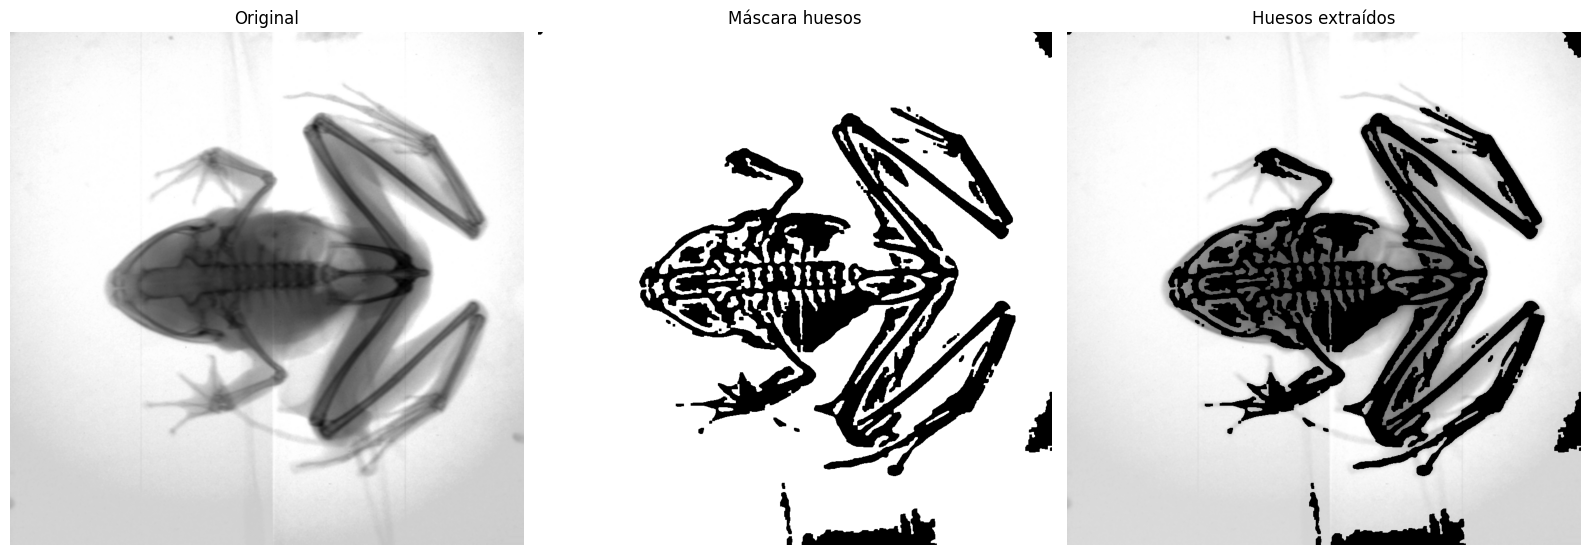

✅ Listo. Archivos guardados en: /content/drive/MyDrive/UR/Projections/pristimantis/processed_bones


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ===============================
# 1. Cargar imagen
# ===============================
ruta = "/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png"
img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError("No se pudo cargar la imagen. Verifica la ruta.")

print("Imagen cargada:", img.shape)

# Crear carpeta de salida
out_dir = os.path.join(os.path.dirname(ruta), "processed_bones")
os.makedirs(out_dir, exist_ok=True)

# ===============================
# 2. Mejorar contraste (CLAHE)
# ===============================
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
img_eq = clahe.apply(img)

# ===============================
# 3. Suavizado que NO destruye bordes
# ===============================
img_filt = cv2.bilateralFilter(img_eq, d=7, sigmaColor=40, sigmaSpace=40)

# ===============================
# 4. Múltiples máscaras de huesos
# ===============================

# A) Huesos muy brillantes (umbral alto fijo)
_, mask_high = cv2.threshold(img_filt, 180, 255, cv2.THRESH_BINARY)

# B) Huesos medianos → Otsu
_, mask_otsu = cv2.threshold(img_filt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# C) Huesos débiles → Adaptive threshold
mask_adapt = cv2.adaptiveThreshold(
    img_filt, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, blockSize=31, C=-2
)

# ===============================
# 5. Fusionar máscaras
# ===============================
mask_combined = cv2.bitwise_or(mask_high, mask_otsu)
mask_combined = cv2.bitwise_or(mask_combined, mask_adapt)

# ===============================
# 6. Limpieza morfológica inteligente
# ===============================
kernel = np.ones((3,3), np.uint8)

# quitar puntos sueltos sin romper huesos
clean = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=1)

# cerrar grietas pequeñas sin engordar hueso
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=2)

# remover objetos pequeños
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean, connectivity=8)
min_area = 150  # tamaño mínimo de objeto válido
mask_final = np.zeros_like(clean)

for i in range(1, num_labels):  # ignorar fondo 0
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        mask_final[labels == i] = 255

# ===============================
# 7. Guardar resultados
# ===============================
cv2.imwrite(os.path.join(out_dir, "bones_mask.png"), mask_final)
cv2.imwrite(os.path.join(out_dir, "bones_overlay.png"), cv2.bitwise_and(img, mask_final))
cv2.imwrite(os.path.join(out_dir, "bones_only.png"), mask_final)

# ===============================
# 8. Mostrar comparación
# ===============================
plt.figure(figsize=(16,6))
plt.subplot(1,3,1), plt.imshow(img, cmap='gray'), plt.title("Original"), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(mask_final, cmap='gray'), plt.title("Máscara huesos"), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(cv2.bitwise_and(img, mask_final), cmap='gray'), plt.title("Huesos extraídos"), plt.axis('off')
plt.tight_layout()
plt.show()

print("✅ Listo. Archivos guardados en:", out_dir)


In [ ]:
import os
import glob
from google.colab import drive

# ====== 1. MONTAR DRIVE ======
drive.mount('/content/drive')

# ====== 2. RUTA BASE DE TRABAJO ======
BASE_PATH = "/content/drive/MyDrive/UR/Projections/pristimantis"  # <-- Ajustado
IMG_PATTERN = "Projection*.png"  # <-- Coincide con tus archivos

# ====== 3. CREAR CARPETA DE MÁSCARAS ======
MASK_DIR = os.path.join(BASE_PATH, "masks")
os.makedirs(MASK_DIR, exist_ok=True)

# ====== 4. BUSCAR IMÁGENES ======
img_paths = sorted(glob.glob(os.path.join(BASE_PATH, IMG_PATTERN)))

print(f"📁 Imágenes encontradas: {len(img_paths)}")
print("Ejemplo de archivos:", img_paths[:3])

if len(img_paths) == 0:
    raise ValueError("❌ No se encontraron imágenes. Revisa la ruta o el patrón de archivo.")

# ====== 5. PROCESAMIENTO (tu pipeline) ======
from skimage.io import imread, imsave
from skimage.morphology import skeletonize, remove_small_objects, binary_opening, disk
from skimage.filters import threshold_otsu
import numpy as np

for img_path in img_paths:
    img = imread(img_path, as_gray=True)

    # ---- UNET + pseudo (simulado con Otsu por ahora) ----
    thresh = threshold_otsu(img)
    mask = img > thresh

    # ---- Limpieza ----
    mask = remove_small_objects(mask, 200)
    mask = binary_opening(mask, disk(3))

    # ---- Skeleton ----
    skel = skeletonize(mask)

    # ---- Guardar máscara ----
    name = os.path.basename(img_path).replace(".png", "_mask.png")
    save_path = os.path.join(MASK_DIR, name)
    imsave(save_path, skel.astype(np.uint8) * 255)

print("✅ Proceso terminado. Máscaras guardadas en:", MASK_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Imágenes encontradas: 180
Ejemplo de archivos: ['/content/drive/MyDrive/UR/Projections/pristimantis/Projection0.png', '/content/drive/MyDrive/UR/Projections/pristimantis/Projection10.png', '/content/drive/MyDrive/UR/Projections/pristimantis/Projection100.png']


/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimantis/masks/Projection0_mask.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimantis/masks/Projection10_mask.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimantis/masks/Projection100_mask.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimantis/masks/Projection102_mask.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimant

✅ Proceso terminado. Máscaras guardadas en: /content/drive/MyDrive/UR/Projections/pristimantis/masks


/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/UR/Projections/pristimantis/masks/Projection98_mask.png is a low contrast image
  return func(*args, **kwargs)


In [ ]:
# ============================
# 📌 CONFIGURACIÓN INICIAL
# ============================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/UR/Projections/pristimantis"  # ✅ Ruta real
IMG_DIR = DATA_DIR                                             # ✅ Imágenes están aquí
MASK_DIR = os.path.join(DATA_DIR, "masks")                     # ✅ Carpeta para máscaras
os.makedirs(MASK_DIR, exist_ok=True)

IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 50
SEED = 42

# ============================
# 📌 UTILIDADES
# ============================
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=-1)

def load_data(img_dir, mask_dir):
    X, Y = [], []
    files = sorted([f for f in os.listdir(img_dir) if f.startswith("Projection") and f.endswith(".png")])
    for f in files:
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_dir, f.replace(".png", "_mask.png"))  # ✅ Coincide con sufijo
        if not os.path.exists(mask_path):
            print("⚠️ No existe máscara para:", f)
            continue
        X.append(load_image(img_path))
        Y.append(load_image(mask_path))
    return np.array(X), np.array(Y)

X, Y = load_data(IMG_DIR, MASK_DIR)
print("✅ Dataset cargado:", X.shape, Y.shape)

# ============================
# 📌 CONSTRUCCIÓN DE UNET
# ============================
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_shape)

    c1 = conv_block(inputs, 32); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPool2D()(c4)

    c5 = conv_block(p4, 512)

    u6 = layers.UpSampling2D()(c5); u6 = layers.Concatenate()([u6, c4]); c6 = conv_block(u6, 256)
    u7 = layers.UpSampling2D()(c6); u7 = layers.Concatenate()([u7, c3]); c7 = conv_block(u7, 128)
    u8 = layers.UpSampling2D()(c7); u8 = layers.Concatenate()([u8, c2]); c8 = conv_block(u8, 64)
    u9 = layers.UpSampling2D()(c8); u9 = layers.Concatenate()([u9, c1]); c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c9)
    model = models.Model(inputs, outputs)
    return model

unet = build_unet()
unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
unet.summary()

# ============================
# 📌 ENTRENAMIENTO
# ============================
history = unet.fit(
    X, Y,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True
)

# ============================
# 📌 PREDICCIÓN CON UNET
# ============================
pred = unet.predict(np.expand_dims(X[0], axis=0))[0, :, :, 0]
pred_bin = (pred > 0.5).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Imagen original"); plt.imshow(X[0].squeeze(), cmap="gray")
plt.subplot(1,3,2); plt.title("Máscara UNet cruda"); plt.imshow(pred, cmap="gray")
plt.subplot(1,3,3); plt.title("UNet binaria"); plt.imshow(pred_bin, cmap="gray")
plt.show()

# ============================
# 📌 POSTPROCESO (Relleno + Morfología + Skeleton)
# ============================
from skimage.morphology import skeletonize

mask = pred_bin.copy()

# 1️⃣ Pseudo fill de huecos
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8))

# 2️⃣ Eliminación de ruido fino
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

# 3️⃣ Skeleton delgado
skeleton = skeletonize(mask).astype(np.uint8)

# 4️⃣ Fusión UNET + relleno + skeleton
final_mask = np.maximum(mask, skeleton)

plt.figure(figsize=(15,4))
plt.subplot(1,4,1); plt.title("UNet binaria"); plt.imshow(pred_bin, cmap="gray")
plt.subplot(1,4,2); plt.title("Post-fill"); plt.imshow(mask, cmap="gray")
plt.subplot(1,4,3); plt.title("Skeleton"); plt.imshow(skeleton, cmap="gray")
plt.subplot(1,4,4); plt.title("Final fusionada"); plt.imshow(final_mask, cmap="gray")
plt.show()

# ============================
# 📌 GUARDA RESULTADO
# ============================
save_path = os.path.join(DATA_DIR, "unet_mask_clean.png")
cv2.imwrite(save_path, (final_mask * 255))
print("✅ Máscara final guardada en:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset cargado: (180, 256, 256, 1) (180, 256, 256, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 7,846,081 (29.93 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 354s 19s/step - accuracy: 0.9872 - loss: 0.2384 - val_accuracy: 0.9884 - val_loss: 0.0409
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 353s 20s/step - accuracy: 0.9872 - loss: 0.0391 - val_accuracy: 0.9884 - val_loss: 0.0304
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 330s 18s/step - accuracy: 0.9869 - loss: 0.0328 - val_accuracy: 0.9884 - val_loss: 0.0299
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 342s 19s/step - accuracy: 0.9870 - loss: 0.0315 - val_accuracy: 0.9884 - val_loss: 0.0294
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 390s 20s/step - accuracy: 0.9869 - loss: 0.0311 - val_accuracy: 0.9884 - val_loss: 0.0284
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 352s 18s/step - accuracy: 0.9874 - loss: 0.0291 - val_accuracy: 0.9884 - val_loss: 0.0280
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 332s 18s/step - accuracy: 0.9865 - loss: 0.0295 - val_accuracy: 0.9884 - val_loss: 0.0277
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 381s 18s/step - accuracy: 0.9864 - loss: 0.0290 - val_accuracy: 0.

In [ ]:
import os

IMG_DIR = "/content/drive/MyDrive/UR/Projections/pristimantis/images"
MASK_DIR = "/content/drive/MyDrive/UR/Projections/pristimantis/masks"

print("📁 Imágenes encontradas:", len(os.listdir(IMG_DIR)) if os.path.exists(IMG_DIR) else "NO EXISTE")
print("📁 Máscaras encontradas:", len(os.listdir(MASK_DIR)) if os.path.exists(MASK_DIR) else "NO EXISTE")

print("\nEjemplo de archivos:")
if os.path.exists(IMG_DIR):
    print(os.listdir(IMG_DIR)[:5])
if os.path.exists(MASK_DIR):
    print(os.listdir(MASK_DIR)[:5])


📁 Imágenes encontradas: 0
📁 Máscaras encontradas: NO EXISTE

Ejemplo de archivos:
[]
